In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
#%unzip large_ds.zip
ds_folder = 'load'

In [21]:
%pip install peft
%pip install transformers
%pip install torch >2.0 #torchvision torchaudio
%pip install monai
%pip install pillow
%pip install matplotlib


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 1.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 1.2 MB/s eta 0:00:0000:0100:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.2/305.2 kB 1.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 1.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 1.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 994.5 kB/s eta 0:00:000:00:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
import torch
from peft import LoraConfig, get_peft_model
import transformers
from torch.utils.data import Dataset
from PIL import Image
import os
import numpy as np
import monai

/home/michael/miniconda3/envs/lorasam/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
#helper function
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [6]:
#model = sam_model_registry["vit_b"](checkpoint="pretrained/sam_vit_b_01ec64.pth")

model = transformers.SamModel.from_pretrained("facebook/sam-vit-base")

print(model)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [7]:
config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["qkv"],
    lora_dropout=0.05,
    bias="none",
    #task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 294912 || all params: 94030384 || trainable%: 0.3136347927708133


In [8]:
def check_mask_size(datapoint):
  m_width, m_height = datapoint['mask'].size
  if m_width != 256 or m_height != 256:
    return False
  i_width, i_height = datapoint['image'].size
  if i_width != 256 or i_height != 256:
    return False
  return True

In [9]:
def create_dataset(load_path, set_type):
    dataset = []
    cnt = 0
    for filename in os.listdir(f'{load_path}/img/{set_type}'):
            if filename.endswith('.png'):
                datapoint = {}
                datapoint['image'] = Image.open(f'{load_path}/img/{set_type}/{filename}')
                datapoint['mask'] = Image.open(f'{load_path}/masks/{set_type}/{filename}')
                if check_mask_size(datapoint):
                  dataset.append(datapoint)
                else:
                  cnt += 1
    print(cnt)
    return dataset

In [10]:
train_data = create_dataset(ds_folder, 'train')
eval_data = create_dataset(ds_folder, 'eval')
test_data = create_dataset(ds_folder, 'test')
print(len(train_data), len(eval_data), len(test_data))

335
20
50
3342 196 383


In [11]:
class SAMDataset(Dataset):
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["mask"])

    # get bounding box prompt
    #prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, return_tensors="pt") #input_boxes=[[prompt]]

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [12]:
processor = transformers.SamProcessor.from_pretrained("facebook/sam-vit-base")

In [13]:
train_dataset = SAMDataset(dataset=train_data, processor=processor)
eval_dataset = SAMDataset(dataset=eval_data, processor=processor)
test_dataset = SAMDataset(dataset=test_data, processor=processor)

In [14]:
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

# subclass trainer source: https://medium.com/deeplearningmadeeasy/how-to-use-a-custom-loss-with-hugging-face-fc9a1f91b39b
class CustomTrainer(transformers.Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        #print(inputs.keys())
        outputs = model(**inputs, multimask_output=False) #multimask_output=False
        # compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = inputs["ground_truth_mask"].float().to(device)
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

        return (loss, outputs) if return_outputs else loss

cuda


In [15]:
args = transformers.TrainingArguments(
    output_dir="output",
    overwrite_output_dir=True,
    num_train_epochs=5,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=2,
    learning_rate=1e-3,
    remove_unused_columns=False,
    logging_steps = 100,
    #load_best_model_at_end=True,
    #evaluation_strategy='epoch',
    save_strategy='epoch',
    #label_names=["labels"], #key error eval_loss
)

trainer = CustomTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=transformers.default_data_collator,
)

In [16]:
trainer.train()

  6%|▌         | 1000/16710 [06:58<1:46:59,  2.45it/s]

{'loss': 0.5157, 'grad_norm': 0.16324500739574432, 'learning_rate': 0.0009401555954518252, 'epoch': 0.3}


 12%|█▏        | 2000/16710 [13:52<1:40:36,  2.44it/s]

{'loss': 0.3687, 'grad_norm': 2.450855016708374, 'learning_rate': 0.0008803111909036506, 'epoch': 0.6}


 18%|█▊        | 3000/16710 [20:46<1:35:14,  2.40it/s]

{'loss': 0.3373, 'grad_norm': 0.44260039925575256, 'learning_rate': 0.0008204667863554758, 'epoch': 0.9}


 24%|██▍       | 4000/16710 [27:33<1:25:04,  2.49it/s]

{'loss': 0.302, 'grad_norm': 0.8756139278411865, 'learning_rate': 0.000760622381807301, 'epoch': 1.2}


 30%|██▉       | 5000/16710 [34:17<1:19:18,  2.46it/s]

{'loss': 0.3012, 'grad_norm': 6.7492995262146, 'learning_rate': 0.0007007779772591262, 'epoch': 1.5}


 36%|███▌      | 6000/16710 [41:02<1:13:45,  2.42it/s]

{'loss': 0.3076, 'grad_norm': 0.17412054538726807, 'learning_rate': 0.0006409335727109516, 'epoch': 1.8}


 42%|████▏     | 7000/16710 [47:47<1:04:51,  2.49it/s]

{'loss': 0.2649, 'grad_norm': 1.1547741889953613, 'learning_rate': 0.0005810891681627768, 'epoch': 2.09}


 48%|████▊     | 8000/16710 [54:30<59:30,  2.44it/s]  

{'loss': 0.2497, 'grad_norm': 1.6709500551223755, 'learning_rate': 0.000521244763614602, 'epoch': 2.39}


 54%|█████▍    | 9000/16710 [1:01:15<50:59,  2.52it/s]

{'loss': 0.2417, 'grad_norm': 0.9314595460891724, 'learning_rate': 0.0004614003590664273, 'epoch': 2.69}


 60%|█████▉    | 10000/16710 [1:08:00<44:56,  2.49it/s]

{'loss': 0.2278, 'grad_norm': 0.28658920526504517, 'learning_rate': 0.0004015559545182526, 'epoch': 2.99}


 66%|██████▌   | 11000/16710 [1:14:41<37:24,  2.54it/s]

{'loss': 0.1953, 'grad_norm': 0.0589209720492363, 'learning_rate': 0.0003417115499700778, 'epoch': 3.29}


 72%|███████▏  | 12000/16710 [1:21:26<33:14,  2.36it/s]

{'loss': 0.2043, 'grad_norm': 0.4890492558479309, 'learning_rate': 0.0002818671454219031, 'epoch': 3.59}


 78%|███████▊  | 13000/16710 [1:28:12<25:00,  2.47it/s]

{'loss': 0.1958, 'grad_norm': 0.11063729971647263, 'learning_rate': 0.0002220227408737283, 'epoch': 3.89}


 84%|████████▍ | 14000/16710 [1:34:53<18:24,  2.45it/s]

{'loss': 0.1707, 'grad_norm': 0.19924582540988922, 'learning_rate': 0.00016217833632555355, 'epoch': 4.19}


 90%|████████▉ | 15000/16710 [1:41:36<11:37,  2.45it/s]

{'loss': 0.1447, 'grad_norm': 0.08859993517398834, 'learning_rate': 0.00010233393177737882, 'epoch': 4.49}


 96%|█████████▌| 16000/16710 [1:48:22<04:46,  2.48it/s]

{'loss': 0.1518, 'grad_norm': 0.4388982653617859, 'learning_rate': 4.2489527229204074e-05, 'epoch': 4.79}


100%|██████████| 16710/16710 [1:53:09<00:00,  2.46it/s]

{'train_runtime': 6789.4732, 'train_samples_per_second': 2.461, 'train_steps_per_second': 2.461, 'train_loss': 0.2575346462174421, 'epoch': 5.0}


TrainOutput(global_step=16710, training_loss=0.2575346462174421, metrics={'train_runtime': 6789.4732, 'train_samples_per_second': 2.461, 'train_steps_per_second': 2.461, 'total_flos': 2.965541948284207e+19, 'train_loss': 0.2575346462174421, 'epoch': 5.0})

In [17]:
#save model
trainer.save_model("saved")
trainer.save_state()
torch.save(trainer.model.state_dict(), "saved/trainer_state.pth")
torch.save(model.state_dict(), "saved_normal_state_dict.pth")

In [18]:
predictions, labels, metrics = trainer.predict(test_dataset)

100%|██████████| 192/192 [01:18<00:00,  2.46it/s]


In [19]:
def normalize_array(arr):
    norm_arr = (arr - np.min(arr)) / (np.max(arr) - np.min(arr))
    return norm_arr

2
(383, 1, 3)
(383, 1, 3, 256, 256)


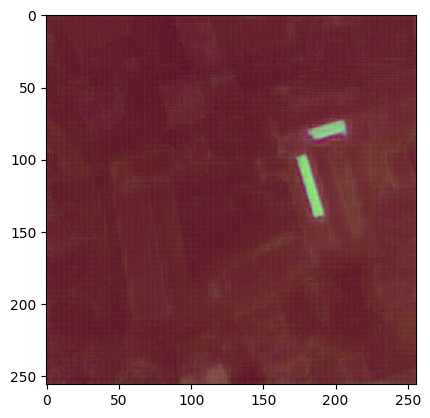

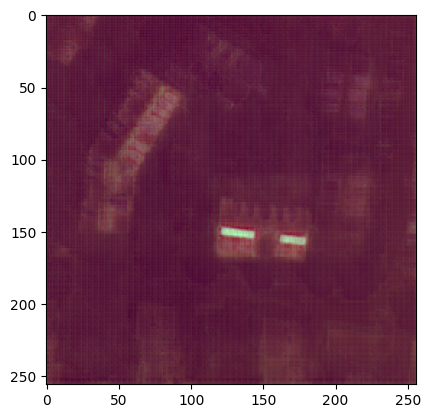

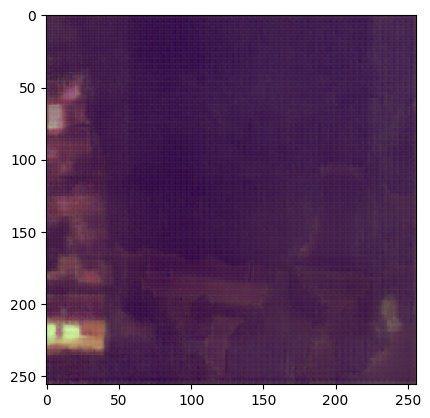

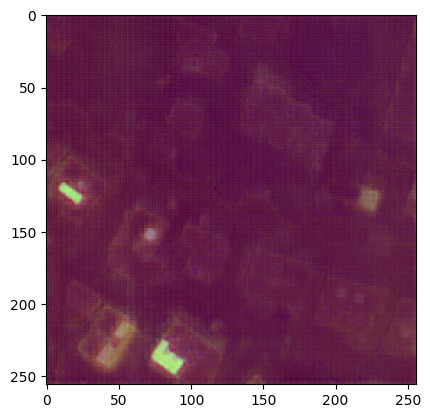

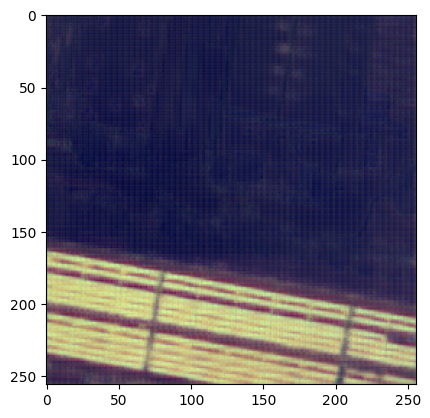

In [22]:
import matplotlib.pyplot as plt

print(len(predictions))
for predict in predictions:
  print(predict.shape)
predict = predictions[1]
predict = predict.squeeze(1)
#preds = np.argmax(predict, axis=-1)
preds = list(predict)
for prediction in preds[:5]:
  prediction = normalize_array(prediction)
  stacked = np.dstack(prediction)
  plt.imshow(stacked)
  plt.show()